In [1]:
import os
import sys

sys.path.insert(0, os.path.abspath("../.."))
from dotenv import load_dotenv

from examples.config import settings

load_dotenv(".env", override=True)
%load_ext autoreload
%autoreload 2

# Deepagent for Research

We will use the `deepagents` package to create a research agent. When using the `deepagents` package, it's important to: 

1. Understand the native tools available
2. Supply task-specific tools
3. Supply task-specific instructions
4. Supply task-specific sub-agents

## Task-Specific Tools 

You can see an overview of the native tools in the [deepagents package README](https://github.com/langchain-ai/deepagents?tab=readme-ov-file#model) as well as the [quickstarts README](https://github.com/langchain-ai/deepagents-quickstarts). We'll extend this with two task-specific tools. 

### Search Tool 

There are different search tools that we can use. For example, we can use [Tavily](https://www.tavily.com/) to search for relevant URLs, then fetches the full webpage content.

### Think Tool 

We'll supply a [think tool](https://www.anthropic.com/engineering/claude-think-tool), which is a useful way to help audit agent decision making. 

In [2]:
from examples.research_agent.tools.tools import tavily_search, think_tool

tools = [tavily_search, think_tool]

## Task-Specific Instructions
 
Next, let's define task specific instructions using [a few prompting techniques for agents](https://youtu.be/XSZP9GhhuAc?si=zowpViL-2j-vI9hA):

### 1. Think Like The Agent
What instructions would you give a new work colleague?
- **Read the question carefully** - What specific information does the user need?
- **Start with broader searches** - Use broad, comprehensive queries first
- **After each search, pause and assess** - Do I have enough to answer? What's still missing?
- **Execute narrower searches as you gather information** - Fill in the gaps.

### 2. Concrete Heuristics (Prevent "Spin-Out" on excessive tool calls)
Use **Hard Limits** to prevent the research agent from calling tools excessively:
- **Stop when you can answer confidently** - Don't keep searching for perfection.
- **Give it budgets** - Use 2-3 search tool calls for simple queries. Use up to 5 for complex queries.
- **Limit** - Always stop after 5 search tool calls if you cannot find the right source(s).

### 3. Show your thinking
After each search tool calling, use [`think_tool` to analyze the results](https://www.anthropic.com/engineering/claude-think-tool):
- What key information did I find? 
- What's missing?
- Do I have enough to answer the question comprehensively?
- Should I search more or provide my answer?

In [3]:
from datetime import datetime

from examples.research_agent.prompts.prompts import (
    RESEARCH_WORKFLOW_INSTRUCTIONS,
    RESEARCHER_INSTRUCTIONS,
    SUBAGENT_DELEGATION_INSTRUCTIONS,
)
from examples.utils import format_messages, show_prompt

In [4]:
show_prompt(RESEARCHER_INSTRUCTIONS)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  You are a research assistant conducting research on the user's input topic. For context, today's date is       │
│  {date}.                                                                                                        │
│                                                                                                                 │
│  <Task>                                                                                                         │
│  Your job is to use tools to gather information about the user's input topic.                                   │
│  You can use any of the research tools provided to you to find resources that can help answer the research      │
│  question.                                                                                                      │
│  You can call these tools in series or in parallel, your research is conducted in a tool-calling loop.          │
│  </Task>                                                                                                        │
│                                                                                                                 │
│  <Available Research Tools>                                                                                     │
│  You have access to two specific research tools:                                                                │
│  1. **tavily_search**: For conducting web searches to gather information                                        │
│  2. **think_tool**: For reflection and strategic planning during research                                       │
│  **CRITICAL: Use think_tool after each search to reflect on results and plan next steps**                       │
│  </Available Research Tools>                                                                                    │
│                                                                                                                 │
│  <Instructions>                                                                                                 │
│  Think like a human researcher with limited time. Follow these steps:                                           │
│                                                                                                                 │
│  1. **Read the question carefully** - What specific information does the user need?                             │
│  2. **Start with broader searches** - Use broad, comprehensive queries first                                    │
│  3. **After each search, pause and assess** - Do I have enough to answer? What's still missing?                 │
│  4. **Execute narrower searches as you gather information** - Fill in the gaps                                  │
│  5. **Stop when you can answer confidently** - Don't keep searching for perfection                              │
│  </Instructions>                                                                                                │
│                                                                                                                 │
│  <Hard Limits>                                                                                                  │
│  **Tool Call Budgets** (Prevent excessive searching):                                                           │
│  - **Simple queries**: Use 2-3 search tool calls maximum                                                        │
│  - **Complex queries**: Use up to 5 search tool calls maximum                                                   │
│  - **Always stop**: After 5 search tool calls if you cannot find the right sources                              │
│                                                       

## Task-Specific Sub-Agents

You can specify [custom subagents](https://github.com/langchain-ai/deepagents?tab=readme-ov-file#subagents) as a means of context isolation. 

Here's well define a sub-agent that can search the web for information. 

In [5]:
# Get current date
current_date = datetime.now().strftime("%Y-%m-%d")

# Create research sub-agent
research_sub_agent = {
    "name": "research-agent",
    "description": "Delegate research to the sub-agent researcher. Only give this researcher one topic at a time.",
    "system_prompt": RESEARCHER_INSTRUCTIONS.format(date=current_date),
    "tools": [tavily_search, think_tool],
}

## Putting it all together

### Instructions

Now, we can look at all of our instructions together. 

In [6]:
# Limits
max_concurrent_research_units = 3
max_researcher_iterations = 3

# Combine orchestrator instructions (RESEARCHER_INSTRUCTIONS only for sub-agents)
INSTRUCTIONS = (
    RESEARCH_WORKFLOW_INSTRUCTIONS
    + "\n\n"
    + "=" * 80
    + "\n\n"
    + SUBAGENT_DELEGATION_INSTRUCTIONS.format(
        max_concurrent_research_units=max_concurrent_research_units,
        max_researcher_iterations=max_researcher_iterations,
    )
)

show_prompt(INSTRUCTIONS)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  # Research Workflow                                                                                            │
│                                                                                                                 │
│  Follow this workflow for all research requests:                                                                │
│                                                                                                                 │
│  1. **Plan**: Create a todo list with write_todos to break down the research into focused tasks                 │
│  2. **Save the request**: Use write_file() to save the user's research question to `/research_request.md`       │
│  3. **Research**: Delegate research tasks to sub-agents using the task() tool - ALWAYS use sub-agents for       │
│  research, never conduct research yourself                                                                      │
│  4. **Synthesize**: Review all sub-agent findings and consolidate citations (each unique URL gets one number    │
│  across all findings)                                                                                           │
│  5. **Write Report**: Write a comprehensive final report to `/final_report.md` (see Report Writing Guidelines   │
│  below)                                                                                                         │
│  6. **Verify**: Read `/research_request.md` and confirm you've addressed all aspects with proper citations and  │
│  structure                                                                                                      │
│                                                                                                                 │
│  ## Research Planning Guidelines                                                                                │
│  - Batch similar research tasks into a single TODO to minimize overhead                                         │
│  - For simple fact-finding questions, use 1 sub-agent                                                           │
│  - For comparisons or multi-faceted topics, delegate to multiple parallel sub-agents                            │
│  - Each sub-agent should research one specific aspect and return findings                                       │
│                                                                                                                 │
│  ## Report Writing Guidelines                                                                                   │
│                                                                                                                 │
│  When writing the final report to `/final_report.md`, follow these structure patterns:                          │
│                                                                                                                 │
│  **For comparisons:**                                                                                           │
│  1. Introduction                                                                                                │
│  2. Overview of topic A                                                                                         │
│  3. Overview of topic B                                                                                         │
│  4. Detailed comparison                                                                                         │
│  5. Conclusion                                                                                                  │
│                                                                                                                 │
│  **For lists/rankings:**                              

### Create the agent

Now, we create our deepagent with these components. 

In [7]:
from deepagents import create_deep_agent
from IPython.display import Image, display
from langchain_google_genai import ChatGoogleGenerativeAI

# Model Gemini 3
model = ChatGoogleGenerativeAI(model=settings.GOOGLE_MODEL_NAME, temperature=0.0)


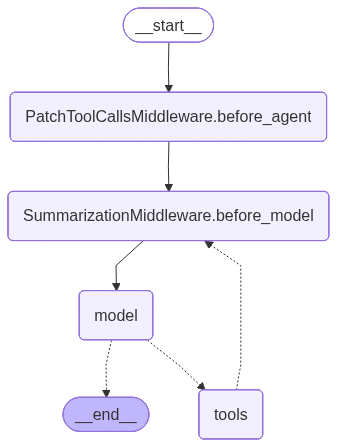

In [8]:
# Create the agent
agent = create_deep_agent(
    model=model,
    tools=tools,
    system_prompt=INSTRUCTIONS,
    subagents=[research_sub_agent],
    # backend=(lambda rt: StateBackend(rt)),
)

# Show the agent
display(Image(agent.get_graph().draw_mermaid_png()))

In [15]:
result = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "Wer ist ENTEGA und wofür steht das Unternehmen?",
            }
        ],
    },
)
format_messages(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Wer ist ENTEGA und wofür steht das Unternehmen?                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: write_file                                                                                        │
│    Args: {                                                                                                      │
│   "file_path": "/research_request.md",                                                                          │
│   "content": "Wer ist ENTEGA und wof\u00fcr steht das Unternehmen?"                                             │
│ }                                                                                                               │
│    ID: 73261f17-4c72-4d54-9bd5-2ef8e82b3215                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated file /research_request.md                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: task                                                                                              │
│    Args: {                                                                                                      │
│   "description": "Research ENTEGA: who they are and what the company stands for. Provide a comprehensive        │
│ overview.",                                                                                                     │
│   "subagent_type": "research-agent"                                                                             │
│ }                                                                                                               │
│    ID: 519ae2a6-2ff2-44de-8751-1261dfa39ad7                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ ## ENTEGA: A Comprehensive Overview                                                                             │
│                                                                                                                 │
│ ENTEGA AG is a prominent energy and infrastructure service provider based in Darmstadt, Germany. The company is │
│ deeply committed to sustainability and climate protection, positioning itself as a key driver of the energy     │
│ transition [3].                                                                                                 │
│                                                                                                                 │
│ ### Who They Are                                                                                                │
│                                                                                                                 │
│ ENTEGA AG is a municipal energy supply company, predominantly owned by the Science City of Darmstadt. It was    │
│ founded in 2007 [1, 3]. As one of the largest regional energy suppliers in Southern Hesse, ENTEGA is a          │
│ significant employer in the region [3].                                                                         │
│                                                                                                                 │
│ Their core business revolves around:                                                                            │
│ *   **Energy Generation and Supply**: ENTEGA is a leading provider of green electricity and climate-friendly    │
│ natural gas. They actively invest in renewable energy generation and the restructuring of energy supply [3].    │
│ *   **Drinking Water Supply**: The company supplies drinking water to the Science City of Darmstadt and seven   │
│ other surrounding cities and municipalities [3].                                                                │
│ *   **Wastewater Treatment**: ENTEGA operates two modern wastewater treatment plants in Darmstadt, processing   │
│ millions of cubic meters of wastewater annually [3].                                                            │
│ *   **Waste Disposal**: They generate environmentally friendly electricity and district heating from waste      │
│ through a waste incineration power plant [3].                                                                   │
│ *   **Energy Efficiency and Digitalization**: ENTEGA also focuses on energy efficiency and offers solutions for │
│ smart metering and digitalization [1].                                                                          │
│                                                                                                                 │
│ ### What the Company Stands For                                                                                 │
│                                                                                                                 │
│ ENTEGA's mission and values are strongly centered on sustainable and environmentally friendly public services   │
│ [3]. Key aspects of what the company stands for include:                                                        │
│                                                                                                                 │
│ *   **Sustainability and Climate Protection**: This is a core commitment, with the company actively promoting   │
│ the energy transition and innovative solutions for an environmentally friendly future [3].                      │
│ *   **Energy Transition**: ENTEGA is dedicated to advancing the energy transition and expanding renewable       │
│ energies [3].                                                                                                   │
│ *   **Climate Protection Initiatives**: They invest in 

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: write_file                                                                                        │
│    Args: {                                                                                                      │
│   "file_path": "/final_report.md",                                                                              │
│   "content": "# ENTEGA: Ein umfassender \u00dcberblick\n\nENTEGA AG ist ein f\u00fchrender Energie- und         │
│ Infrastrukturdienstleister mit Sitz in Darmstadt, Deutschland. Das Unternehmen engagiert sich stark f\u00fcr    │
│ Nachhaltigkeit und Klimaschutz und positioniert sich als wichtiger Treiber der Energiewende [3].\n\n## Wer ist  │
│ ENTEGA?\n\nDie ENTEGA AG ist ein kommunales Energieversorgungsunternehmen, das mehrheitlich von der             │
│ Wissenschaftsstadt Darmstadt gehalten wird. Es wurde 2007 gegr\u00fcndet [1, 3]. Als einer der                  │
│ gr\u00f6\u00dften regionalen Energieversorger in S\u00fcdhessen ist ENTEGA ein bedeutender Arbeitgeber in der   │
│ Region [3].\n\nDas Kerngesch\u00e4ft umfasst:\n\n*   **Energieerzeugung und -versorgung**: ENTEGA ist ein       │
│ f\u00fchrender Anbieter von \u00d6kostrom und klimafreundlichem Erdgas. Das Unternehmen investiert aktiv in die │
│ Erzeugung erneuerbarer Energien und die Umstrukturierung der Energieversorgung [3].\n*                          │
│ **Trinkwasserversorgung**: Das Unternehmen versorgt die Wissenschaftsstadt Darmstadt und sieben weitere         │
│ umliegende St\u00e4dte und Gemeinden mit Trinkwasser [3].\n*   **Abwasserbehandlung**: ENTEGA betreibt zwei     │
│ moderne Kl\u00e4ranlagen in Darmstadt, die j\u00e4hrlich Millionen Kubikmeter Abwasser aufbereiten [3].\n*      │
│ **Abfallentsorgung**: Durch ein M\u00fcllheizkraftwerk wird umweltfreundlicher Strom und Fernw\u00e4rme aus     │
│ Abfall erzeugt [3].\n*   **Energieeffizienz und Digitalisierung**: ENTEGA konzentriert sich auch auf            │
│ Energieeffizienz und bietet L\u00f6sungen f\u00fcr Smart Metering und Digitalisierung an [1].\n\n## Wof\u00fcr  │
│ steht das Unternehmen?\n\nDie Mission und die Werte von ENTEGA sind stark auf nachhaltige und umweltfreundliche │
│ \u00f6ffentliche Dienstleistungen ausgerichtet [3]. Wichtige Aspekte, wof\u00fcr das Unternehmen steht,         │
│ sind:\n\n*   **Nachhaltigkeit und Klimaschutz**: Dies ist ein zentrales Engagement, wobei das Unternehmen die   │
│ Energiewende und innovative L\u00f6sungen f\u00fcr eine umweltfreundliche Zukunft aktiv f\u00f6rdert [3].\n*    │
│ **Energiewende**: ENTEGA widmet sich der F\u00f6rderung der Energiewende und dem Ausbau erneuerbarer Energien   │
│ [3].\n*   **Klimaschutzinitiativen**: Das Unternehmen investiert in Projekte zur Reduzierung seines             │
│ CO\u2082-Fu\u00dfabdrucks, wie beispielsweise den Windpark Global Tech I [3].\n*   **Hohe Umweltstandards**:    │
│ Das Unternehmen legt gro\u00dfen Wert auf die Einhaltung hoher Umweltstandards, die durch regelm\u00e4\u00dfige │
│ technische Anpassungen und qualifiziertes Personal gew\u00e4hrleistet werden [3].\n*   **Regionale              │
│ Verantwortung**: ENTEGA zeigt ein starkes Engagement f\u00fcr seine Region, indem es lokale Initiativen         │
│ unterst\u00fctzt und an gemeinn\u00fctzige Organisationen spendet [3].\n*   **Innovation**: Das Unternehmen     │
│ nutzt fortschrittliche Technologien, einschlie\u00dflich k\u00fcnstlicher Intelligenz, um die Effizienz der     │
│ Energiewirtschaft zu steigern [3].\n*   **Partnerschaften f\u00fcr nachhaltige L\u00f6sungen**: ENTEGA arbeitet │
│ mit Partnern zusammen, um nachhaltige L\u00f6sungen f\u0

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated file /final_report.md                                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ ENTEGA AG ist ein führender Energie- und Infrastrukturdienstleister mit Sitz in Darmstadt, Deutschland. Das     │
│ Unternehmen engagiert sich stark für Nachhaltigkeit und Klimaschutz und positioniert sich als wichtiger Treiber │
│ der Energiewende.                                                                                               │
│                                                                                                                 │
│ ## Wer ist ENTEGA?                                                                                              │
│                                                                                                                 │
│ Die ENTEGA AG ist ein kommunales Energieversorgungsunternehmen, das mehrheitlich von der Wissenschaftsstadt     │
│ Darmstadt gehalten wird. Es wurde 2007 gegründet. Als einer der größten regionalen Energieversorger in          │
│ Südhessen ist ENTEGA ein bedeutender Arbeitgeber in der Region.                                                 │
│                                                                                                                 │
│ Das Kerngeschäft umfasst:                                                                                       │
│                                                                                                                 │
│ *   **Energieerzeugung und -versorgung**: ENTEGA ist ein führender Anbieter von Ökostrom und klimafreundlichem  │
│ Erdgas. Das Unternehmen investiert aktiv in die Erzeugung erneuerbarer Energien und die Umstrukturierung der    │
│ Energieversorgung.                                                                                              │
│ *   **Trinkwasserversorgung**: Das Unternehmen versorgt die Wissenschaftsstadt Darmstadt und sieben weitere     │
│ umliegende Städte und Gemeinden mit Trinkwasser.                                                                │
│ *   **Abwasserbehandlung**: ENTEGA betreibt zwei moderne Kläranlagen in Darmstadt, die jährlich Millionen       │
│ Kubikmeter Abwasser aufbereiten.                                                                                │
│ *   **Abfallentsorgung**: Durch ein Müllheizkraftwerk wird umweltfreundlicher Strom und Fernwärme aus Abfall    │
│ erzeugt.                                                                                                        │
│ *   **Energieeffizienz und Digitalisierung**: ENTEGA konzentriert sich auch auf Energieeffizienz und bietet     │
│ Lösungen für Smart Metering und Digitalisierung an.                                                             │
│                                                                                                                 │
│ ## Wofür steht das Unternehmen?                                                                                 │
│                                                                                                                 │
│ Die Mission und die Werte von ENTEGA sind stark auf nachhaltige und umweltfreundliche öffentliche               │
│ Dienstleistungen ausgerichtet. Wichtige Aspekte, wofür das Unternehmen steht, sind:                             │
│                                                                                                                 │
│ *   **Nachhaltigkeit und Klimaschutz**: Dies ist ein zentrales Engagement, wobei das Unternehmen die            │
│ Energiewende und innovative Lösungen für eine umweltfreundliche Zukunft aktiv fördert.                          │
│ *   **Energiewende**: ENTEGA widmet sich der Förderung der Energiewende und dem Ausbau erneuerbarer Energien.   │
│ *   **Klimaschutzinitiativen**: Das Unternehmen investiert in Projekte zur Reduzierung seines CO₂-Fußabdrucks,  │
│ wie beispielsweise den Windpark Global Tech I.         

In [16]:
result

{'messages': [HumanMessage(content='Wer ist ENTEGA und wofür steht das Unternehmen?', additional_kwargs={}, response_metadata={}, id='18ea8aea-ed3a-4283-96fa-f814a0755b65'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'write_file', 'arguments': '{"file_path": "/research_request.md", "content": "Wer ist ENTEGA und wof\\u00fcr steht das Unternehmen?"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--019af827-36b0-7510-8ed1-6c4a3d65cdb2-0', tool_calls=[{'name': 'write_file', 'args': {'file_path': '/research_request.md', 'content': 'Wer ist ENTEGA und wofür steht das Unternehmen?'}, 'id': '73261f17-4c72-4d54-9bd5-2ef8e82b3215', 'type': 'tool_call'}], usage_metadata={'input_tokens': 6305, 'output_tokens': 109, 'total_tokens': 6414, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reason

In [17]:
from deepagents.backends.utils import file_data_to_string

# Convert a specific file to string
file_content = file_data_to_string(result["files"]["/final_report.md"])
show_prompt(file_content)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  # ENTEGA: Ein umfassender Überblick                                                                            │
│                                                                                                                 │
│  ENTEGA AG ist ein führender Energie- und Infrastrukturdienstleister mit Sitz in Darmstadt, Deutschland. Das    │
│  Unternehmen engagiert sich stark für Nachhaltigkeit und Klimaschutz und positioniert sich als wichtiger        │
│  Treiber der Energiewende [3].                                                                                  │
│                                                                                                                 │
│  ## Wer ist ENTEGA?                                                                                             │
│                                                                                                                 │
│  Die ENTEGA AG ist ein kommunales Energieversorgungsunternehmen, das mehrheitlich von der Wissenschaftsstadt    │
│  Darmstadt gehalten wird. Es wurde 2007 gegründet [1, 3]. Als einer der größten regionalen Energieversorger in  │
│  Südhessen ist ENTEGA ein bedeutender Arbeitgeber in der Region [3].                                            │
│                                                                                                                 │
│  Das Kerngeschäft umfasst:                                                                                      │
│                                                                                                                 │
│  *   **Energieerzeugung und -versorgung**: ENTEGA ist ein führender Anbieter von Ökostrom und                   │
│  klimafreundlichem Erdgas. Das Unternehmen investiert aktiv in die Erzeugung erneuerbarer Energien und die      │
│  Umstrukturierung der Energieversorgung [3].                                                                    │
│  *   **Trinkwasserversorgung**: Das Unternehmen versorgt die Wissenschaftsstadt Darmstadt und sieben weitere    │
│  umliegende Städte und Gemeinden mit Trinkwasser [3].                                                           │
│  *   **Abwasserbehandlung**: ENTEGA betreibt zwei moderne Kläranlagen in Darmstadt, die jährlich Millionen      │
│  Kubikmeter Abwasser aufbereiten [3].                                                                           │
│  *   **Abfallentsorgung**: Durch ein Müllheizkraftwerk wird umweltfreundlicher Strom und Fernwärme aus Abfall   │
│  erzeugt [3].                                                                                                   │
│  *   **Energieeffizienz und Digitalisierung**: ENTEGA konzentriert sich auch auf Energieeffizienz und bietet    │
│  Lösungen für Smart Metering und Digitalisierung an [1].                                                        │
│                                                                                                                 │
│  ## Wofür steht das Unternehmen?                                                                                │
│                                                                                                                 │
│  Die Mission und die Werte von ENTEGA sind stark auf nachhaltige und umweltfreundliche öffentliche              │
│  Dienstleistungen ausgerichtet [3]. Wichtige Aspekte, wofür das Unternehmen steht, sind:                        │
│                                                                                                                 │
│  *   **Nachhaltigkeit und Klimaschutz**: Dies ist ein zentrales Engagement, wobei das Unternehmen die           │
│  Energiewende und innovative Lösungen für eine umweltf

Trace: 

https://smith.langchain.com/public/72d23852-4616-4bcc-8d8a-b0d1905c945b/r